In [1]:
# initial imports

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from rbf_regression import RBFRegression

In [2]:
# Read the Image
image_name = './denoise_example.png'
img = Image.open(image_name).convert('RGB')
img = img.resize((img.size[0] // 2, img.size[1] // 2))
img = np.array(img) / 255 
img = img.astype(np.float32)

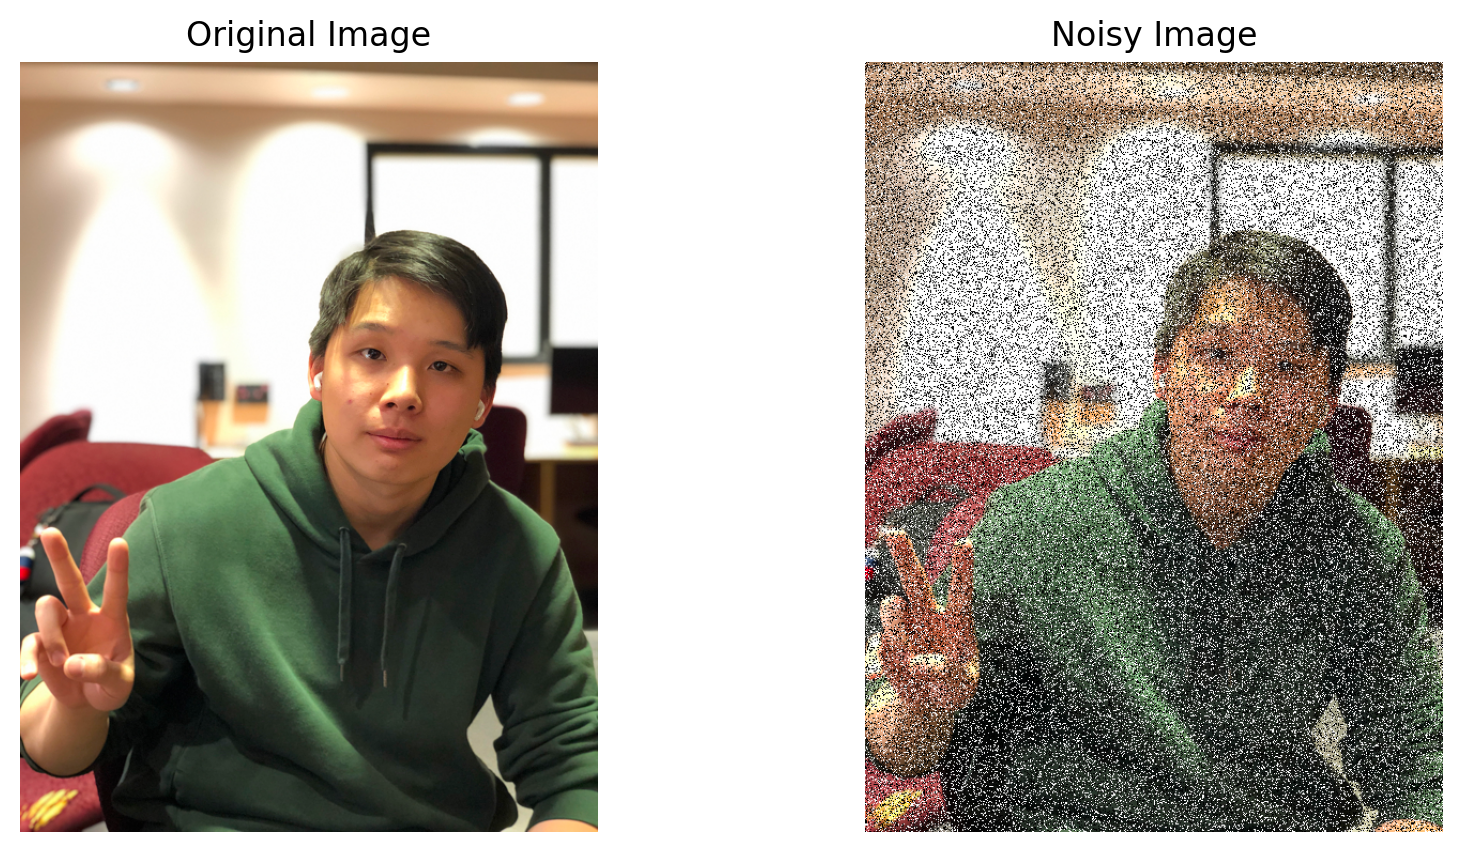

In [3]:
pepper_rgb = np.array([0, 0, 0])
pepper_rgb = pepper_rgb.astype(np.float32) / 255
salt_rgb = np.array([255, 255, 255])
salt_rgb = salt_rgb.astype(np.float32) / 255

def add_salt_and_pepper_noise(image, salt_prob, pepper_prob):
    noisy_image = np.copy(image)
    
    # Add salt noise
    salt_pixels = np.random.rand(*image.shape[:-1]) < salt_prob
    noisy_image[salt_pixels] = 1

    # Add pepper noise
    pepper_pixels = np.random.rand(*image.shape[:-1]) < pepper_prob
    noisy_image[pepper_pixels] = 0

    return noisy_image

noisy_img = add_salt_and_pepper_noise(img, 0.2, 0.2)
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=200)
axs[0].imshow(img)
axs[0].set_title('Original Image')
axs[1].imshow(noisy_img)
axs[1].set_title('Noisy Image')
axs[0].set_axis_off()
axs[1].set_axis_off()
plt.show()

In [4]:
def denoising(im, spacing, width, patch_size, l2_coeff, tolerance):
    im_rec = im.copy() # reconstruction or denoised
    H, W = im.shape[:2]

    # i corresponds to left-to-right
    # j corresponds to up-to-down
    for i in range(0, W-patch_size+1, patch_size):
        for j in range(0, H-patch_size+1, patch_size):
            # Grid of pixel coordinates in the patch
            XX, YY = np.meshgrid(np.arange(i, i+patch_size), np.arange(j, j+patch_size))
            P = np.stack([YY, XX], axis=0).reshape(-1, 2)
            
            # Uses squared distance to find indcies to be filled
            patch = im[j:j+patch_size, i:i+patch_size]
            ref1 = ((patch - salt_rgb) ** 2).sum(axis=2)
            ref2 = ((patch - pepper_rgb) ** 2).sum(axis=2)
            cond = np.logical_or(ref1 <= tolerance, ref2 <= tolerance)
            index_fill = np.argwhere(cond) # if close to fill_rgb, then fill
            index_data = np.argwhere(~cond) # if not close to fill_rgb, then data
            idx_data = np.sort(index_data[:,1]*ref1.shape[0]+index_data[:,0])
            idx_fill = np.sort(index_fill[:,1]*ref1.shape[0]+index_fill[:,0])

            # Place RBFs over image patch with even spacing and same widths
            XX, YY = np.meshgrid(list(range(i, i+patch_size, spacing)),
                                list(range(j, j+patch_size, spacing)))

            centers = np.array((XX.flatten(), YY.flatten()), dtype=np.float32).T
            num_centers = centers.shape[0]
            widths = np.ones(shape=(num_centers, 1), dtype=np.float32) * width

            # Construct one model for each color channel
            red_model = RBFRegression(centers=centers, widths=widths)
            green_model = RBFRegression(centers=centers, widths=widths)
            blue_model = RBFRegression(centers=centers, widths=widths)
            
            # If there are pixels that need to be filled, then we try to train the models and fill.
            # Otherwise, we use the original patch
            if (idx_fill.size>0):
                # print('Reconstructing patch at selected color')
                if(idx_data.size <= num_centers):
                    # print('Not enough pixels to estimate RBF model! copying patch\n')
                    patch_rec = patch.copy()
                else:
                    # Valid locations for sampling pixels
                    P_data = P[idx_data]

                    # Reconstruct each colour layer using a separate RBF model
                    # Red channel
                    patch_R = patch[:,:,0]
                    z_R = patch_R.reshape(patch_R.size, 1, order='F')
                    z_R = z_R[idx_data]
                    red_model.fit_with_l2_regularization(P_data, z_R, l2_coeff)
                    
                    # Green channel
                    patch_G = patch[:,:,1]
                    z_G = patch_G.reshape(patch_G.size, 1, order='F')
                    z_G = z_G[idx_data]
                    green_model.fit_with_l2_regularization(P_data, z_G, l2_coeff)
                    
                    # Blue channel
                    patch_B = patch[:,:,2]
                    z_B = patch_B.reshape(patch_B.size, 1, order='F')
                    z_B = z_B[idx_data]
                    blue_model.fit_with_l2_regularization(P_data, z_B, l2_coeff)
                    
                    # Reconstruct pixel values at fill-in locations
                    P_fill = P[idx_fill]
                    fill_R = red_model.predict(P_fill)
                    fill_G = green_model.predict(P_fill)
                    fill_B = blue_model.predict(P_fill)
                    
                    # Assemble reconstructed patch
                    patch_rec = patch.copy()
                    patch_rec[index_fill[:,0], index_fill[:,1], 0] = np.squeeze(np.asarray(fill_R)) # Red
                    patch_rec[index_fill[:,0], index_fill[:,1], 1] = np.squeeze(np.asarray(fill_G)) # Green
                    patch_rec[index_fill[:,0], index_fill[:,1], 2] = np.squeeze(np.asarray(fill_B)) # Blue
            else:
                # print('Copying patch at %d--%d\n'%(i,j))
                patch_rec = patch.copy()
            im_rec[j:j+patch_size, i:i+patch_size] = patch_rec
    im_rec = np.clip(im_rec, 0, 1)
    return im_rec

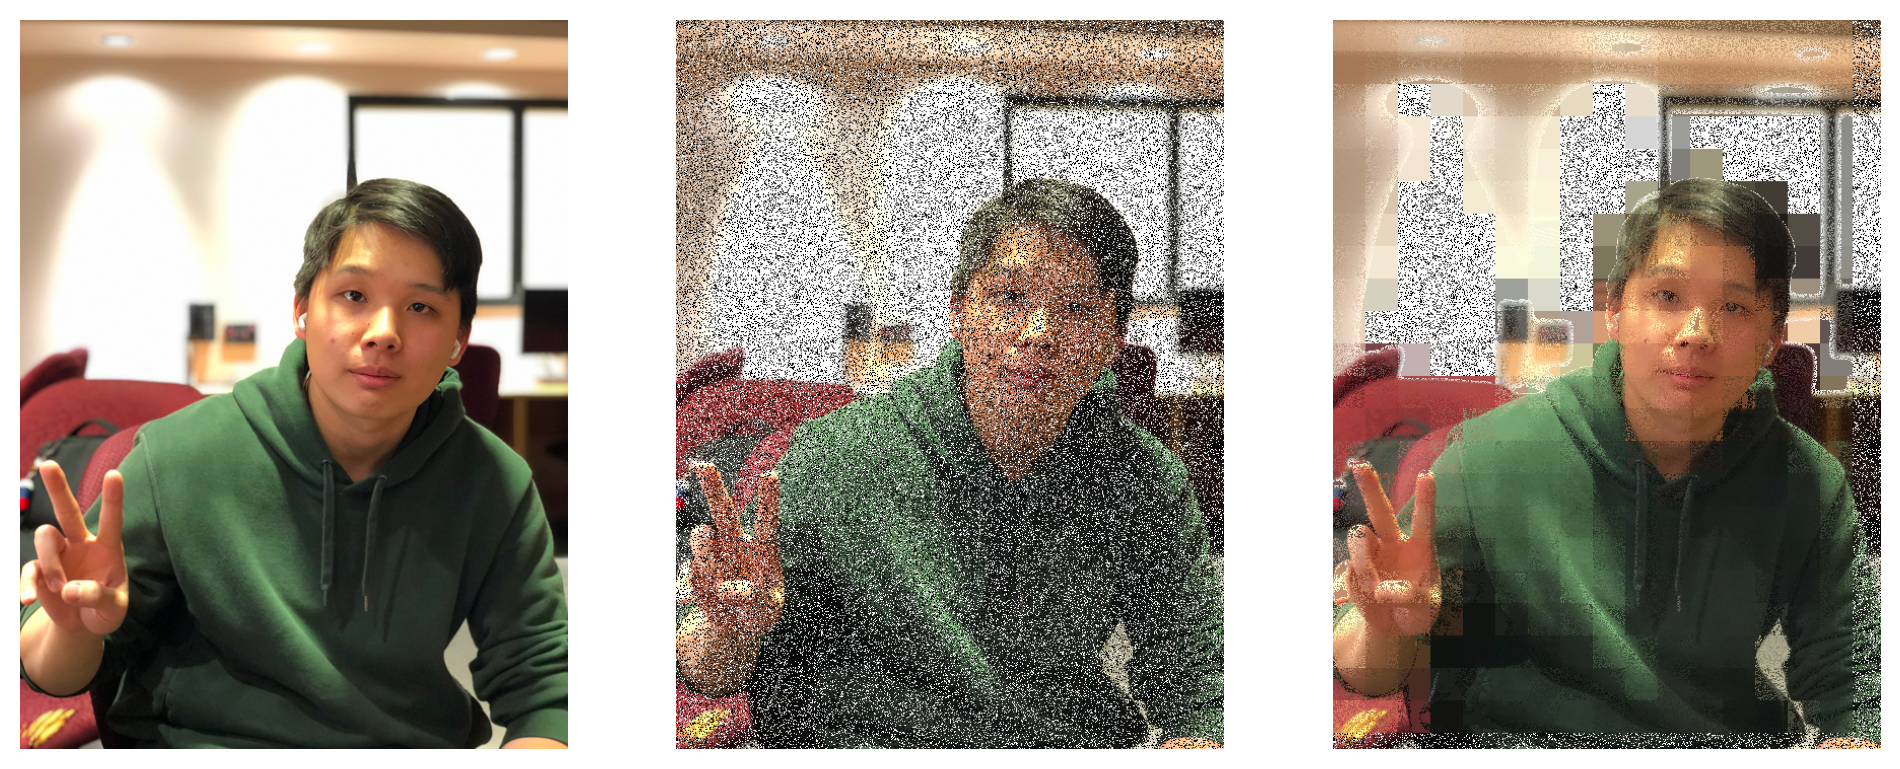

In [5]:
l2_coef = 2
tolerance = 0.01
spacing = 16 # 1 <= spacing <= 9
width = 4 # 1 <= width <= 2 * spacing
patch_size = 32 # >=1
img_recs = []
img_rec = denoising(noisy_img, 
                    spacing=spacing, width=width, 
                    patch_size=patch_size, l2_coeff=l2_coef, 
                    tolerance=tolerance)
fig, axs = plt.subplots(1, 3, figsize=(12, 5), dpi=200)
axs[0].imshow(img)
axs[1].imshow(noisy_img)
axs[2].imshow(img_rec)
axs[0].set_axis_off()
axs[1].set_axis_off()
axs[2].set_axis_off()
plt.show()

You can see that the white blurred background is not captured by the image denoiser, thus failing to remove the noise. This is likely because the denoiser is trained on natural images, and the white background is not a common feature in natural images.

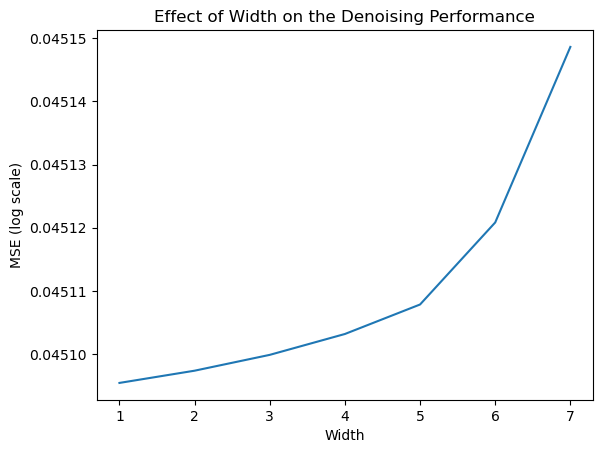

In [6]:
l2_coef = 2.5
tolerance = 0.01

spacing = 16
patch_size = 32
mses = []
widths = np.arange(1, spacing//2).astype(np.int32)
for width in widths:
    img_rec = denoising(noisy_img, 
                        spacing=spacing, width=width, 
                        patch_size=patch_size, l2_coeff=l2_coef, 
                        tolerance=tolerance)
    mse = ((img_rec - img)**2).mean()
    mses.append(mse)
plt.plot(widths, np.log(1+np.array(mses)))
plt.xlabel('Width')
plt.ylabel('MSE (log scale)')
plt.title('Effect of Width on the Denoising Performance')
plt.show()

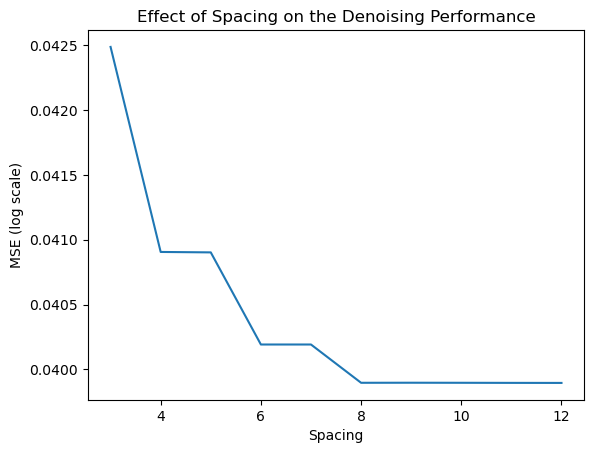

In [7]:
l2_coef = 2.0
tolerance = 0.01

width = 3
patch_size = 16
mses = []
spacings = np.arange(width, width*4+1).astype(np.int32)
for spacing in spacings:
    img_rec = denoising(noisy_img, 
                        spacing=spacing, width=width, 
                        patch_size=patch_size, l2_coeff=l2_coef, 
                        tolerance=tolerance)
    mse = ((img_rec - img)**2).mean()
    mses.append(mse)
plt.plot(spacings, np.log(1+np.array(mses)))
plt.xlabel('Spacing')
plt.ylabel('MSE (log scale)')
plt.title('Effect of Spacing on the Denoising Performance')
plt.show()